# More on CWT and wavelets

This builds on "Introduction to signal transformation", providing more exploration of CWT and its scaleograms and wavelets.

## Contents:
* [Notebook set-up](#setup)
* [Choosing wavelets](#choose)
    * [Wavelet families](#families)
    * [CWT using different wavelets on the same signal](#cwt_different)
    * [How to choose which wavelet to use](#choose_wavelet)
    * [How to choose which scales to use](#choose_scales)
* [Understanding scaleograms](#understanding)
    * [Increasing the maximum wavelet scale](#max)
    * [Using decimal scales](#decimal)
    * [Using log scales](#log)
    * [Changing the units of the signal](#units)
    * [Smoothing the signal](#smooth)
    * [Using CWT on FHR records with known anomalies](#anomalies)

## Notebook set-up <a class="anchor" id="setup"></a>

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal

In [2]:
# Import example of a FHR and UCR to be used in notebook (FHR cleaned, UC not)
fhr = pd.read_csv('data_fhr_clean/1001.csv')['FHR'].tail(90*60)
ctg = pd.read_csv('data_csv/1001.csv')
uc = ctg['UC']

## Choosing wavelets <a class="anchor" id="choose"></a>

### Wavelet families <a class="anchor" id="families"></a>

Wavelets are organised into families, with some best for DWT and CWT. The continuous wavelets available in the package `pywt` are displayed below.

**Analytic wavelets** (also known as **complex wavelets**) are best for CWT as they don't have negative frequency component (so they only responsd to non-negative frequencies in the signal). This results in the coefficients being less oscillatory (having periodic vibrations) than for real-valued wavelets.[[source]](https://www.sciencedirect.com/topics/engineering/analytic-wavelet#:~:text=A%20complex%20(or%20analytic)%20wavelet,case%20of%20a%20real%20wavelet.) Examples:
* Morse Wavelets
* Bump Wavelets
* Analytic Morse Wavelet

You can use other wavelets that are not complex, like Ricker wavelets.

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_28351/2134413181.py:4: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
/tmp/ipykernel_28351/2134413181.py:4: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
/tmp/ipykernel_28351/2134413181.py

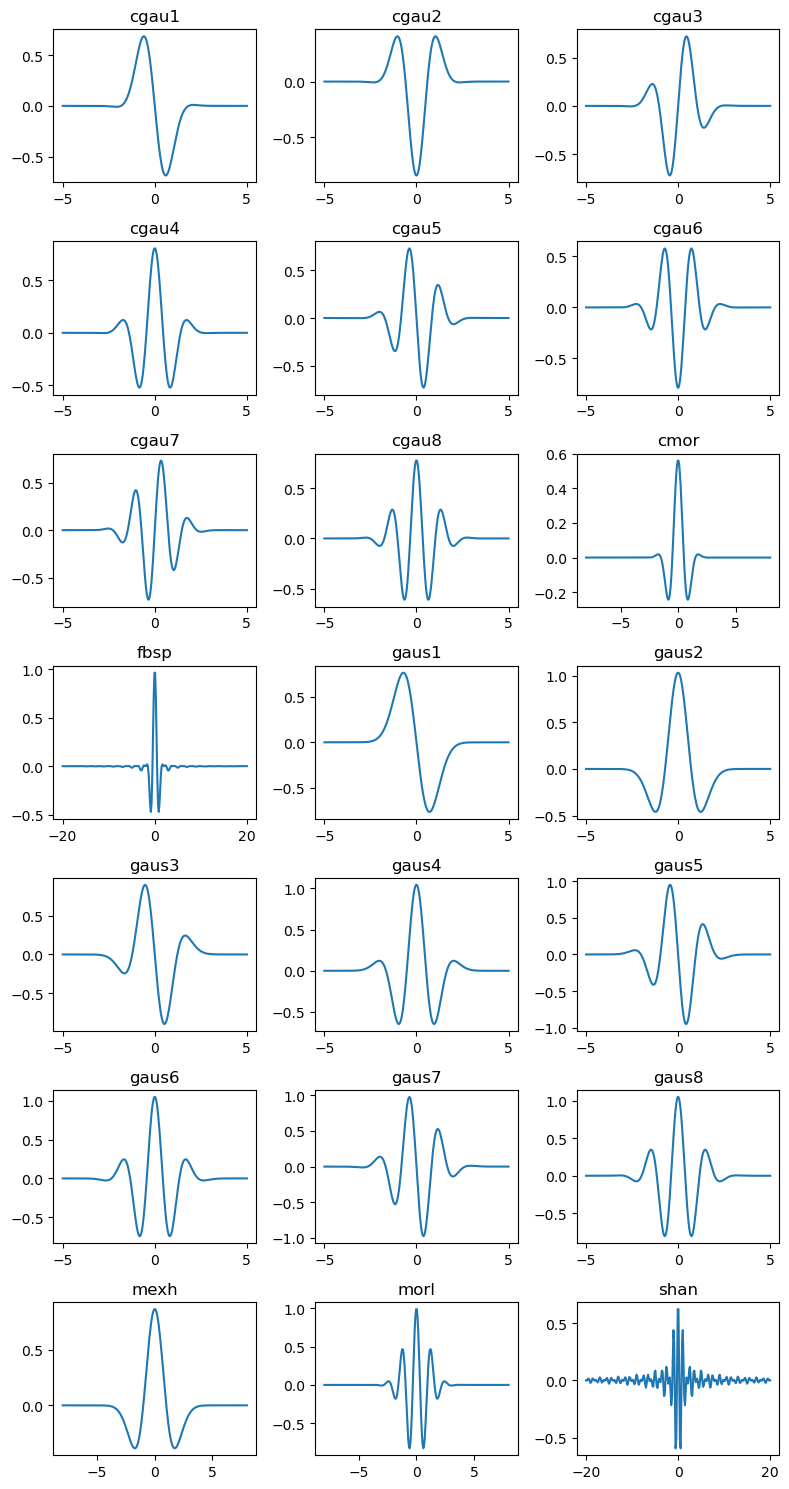

In [3]:
continuous_wavelets = pywt.wavelist(kind='continuous')
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(8, 15))
for wavelet, ax in zip(continuous_wavelets, ax.ravel()):
    wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
    ax.plot(x_values, wavelet_function)
    ax.set_title(wavelet)
plt.tight_layout()
plt.show()

A common example is the **Morlet wavelet**. There are two versions of the Morlet wavelet:
* Real-valued version - sometimes referred to as "real Morlet" or just "Morlet wavelet" - sine wave tapered by a Gaussian
* Complex version - sometimes referred to as "complex Morlet" or "Gabor wavelet" - complex-valued sine wave tapered by a real-valued Gaussian - the complex Morlet wavelet has real and imaginary dimensions as it incorporates complex numbers (numbers with real and imaginary parts).

**Definitions:**
* **Real number** = includes negative and positive: integers, decimals and fractional numbers
* **Imaginary number** = square root of negative number (as you can't - all numbers squared become positive) - can think of as $\sqrt{-1}$ multiplied by a real number with examples like:
    * $\sqrt{-1}$ (i.e. i) * $\sqrt{4}$ (i.e. 2) = 2i
    * $\sqrt{-1}$ (i.e. i) * $\sqrt{3}$ (can't simplify) = i $\sqrt{3}$
* **Complex number** = sum of real number and imaginary number

ContinuousWavelet morl
  Family name:    Morlet wavelet
  Short name:     morl
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


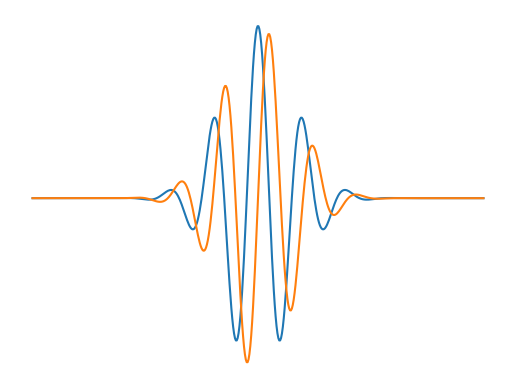

In [4]:
print(pywt.ContinuousWavelet('morl'))

# Source: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html

# Define the sampling rate/frequency, fundamental frequency, and number of
# cycles per frequency (or omega), and the scale factor
fs = 500
freq = 5
n_cycles = 5

# Calculate wavelet length (e.g. 5 * (500/5) = 500)
wavelet_len = int(n_cycles * fs / freq)

# Plot both real and imaginary dimensions of the wavelet
_, ax = plt.subplots()
ax.plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.plot(np.imag(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.set_axis_off()

Another example is the **ricker wavelet**, which is also known as the **mexican hat wavelet**.

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


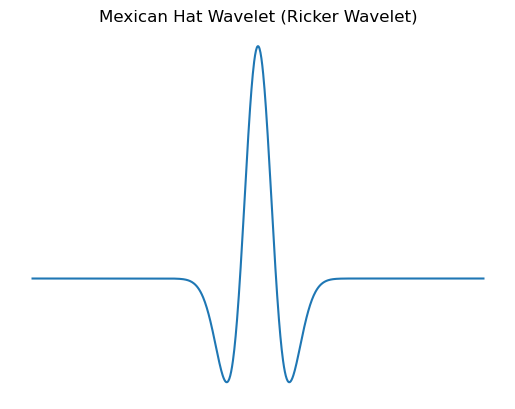

In [5]:
print(pywt.ContinuousWavelet('mexh'))

# Parameters
width = 40
t = np.linspace(-5, 5, 1000, endpoint=False)  # Time vector

# Create the Mexican Hat wavelet
mexican_hat_wavelet = signal.ricker(len(t), width)

# Plot the Mexican Hat wavelet
_, ax = plt.subplots()
ax.plot(t, mexican_hat_wavelet)
ax.set_title('Mexican Hat Wavelet (Ricker Wavelet)')
ax.set_axis_off()
plt.show()

### CWT using different wavelets on the same signal <a class="anchor" id="cwt_different"></a>

A simple example of using different wavelets on the same signal is shown below, similar to [[this paper]](#https://www.hindawi.com/journals/ijhy/2021/9938584/fig1/)

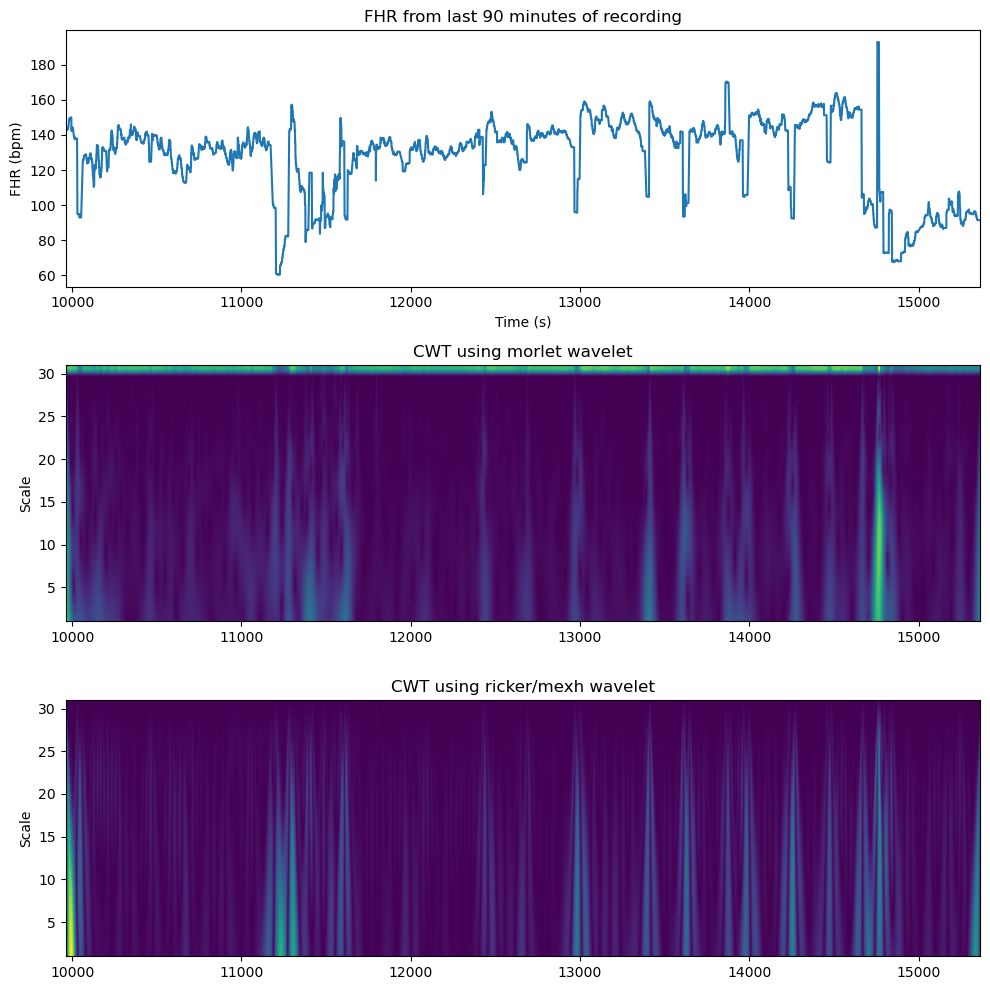

In [6]:
def cwt_plot_simple(wavelet, axes):
    '''
    Perform CWT using scipy and the provided wavelet
    Then plot spectogram on provided axes
    Using widths 1 to 30
    '''
    # Perform CWT with Morlet and plot
    cwtmatr = signal.cwt(fhr, wavelet, np.arange(1, 31))

    # Plot the spectogram
    magn = np.absolute(cwtmatr)
    axes.imshow(magn,
                extent=[min(fhr.index), max(fhr.index), 1, 31],
                aspect='auto')
    axes.set_ylabel('Scale')


# Plot FHR
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes[0].plot(fhr)
axes[0].margins(x=0)
axes[0].set_title('FHR from last 90 minutes of recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('FHR (bpm)')

# CWT with different wavelets
cwt_plot_simple(signal.morlet2, axes[1])
axes[1].set_title('CWT using morlet wavelet')
cwt_plot_simple(signal.ricker, axes[2])
axes[2].set_title('CWT using ricker/mexh wavelet')

plt.tight_layout()
plt.show()

### How to choose which wavelet to use <a class="anchor" id="choose_wavelet"></a>

<mark>Still unclear on this</mark>

### How to choose what scales to use <a class="anchor" id="choose_scales"></a>

<mark>Still unclear on this</mark>

In DWT, you scale wavelets by factor of 2, reducing equivalent frequency by an octave.

In CWT, you can analyse the wavelet by intermediary scales within each octave, allowing for fine-scale analysis, and referred to as the number of scales per octave. Higher number of scales per octave --> finer scale discretisation.

Typical values of scales per octave are 10, 12, 16 and 32. They are multiplied by the sampling interval.[[source]](https://www.youtube.com/watch?v=F7Lg-nFYooU)

## Understanding scaleograms <a class="anchor" id="understanding"></a>

In this section, we vary the characteristics of the input signal and parameters of CWT and look at the impact this has on the produced scaleogram.

In [7]:
def cwt_plot(sig_ax,
             cwt_ax,
             scales=np.arange(1, 31),
             sig=fhr,
             sig_title='FHR from last 90 minutes of CTG',
             cwt_title='CWT of signal'):
    '''
    Plot the signal, perform CWT and then plot the scaleogram
    Inputs:
    - sig_ax - axis to plot the signal onto
    - cwt_ax - axis to plot the scaleogram onto
    - scales - array containing each of the wavelet scales to use
    - sig - series, contains the time-series/signal to input
    '''
    # Plot FHR
    sig_ax.plot(sig)
    sig_ax.margins(x=0)
    sig_ax.set_title(sig_title)
    sig_ax.set_xlabel('Time (s)')
    sig_ax.set_ylabel('FHR (bpm)')

    # Perform CWT
    cwtmatr = signal.cwt(sig, signal.morlet2, scales)

    # Plot the scaleogram
    magn = np.absolute(cwtmatr)
    im = cwt_ax.imshow(
        magn,
        extent=[min(sig.index), max(sig.index), scales.min(), scales.max()],
        aspect='auto',
    )
    cwt_ax.set_xlabel('Time (s)')
    cwt_ax.set_ylabel('Wavelet scale (inverse of frequency)')
    cwt_ax.set_title(cwt_title)
    plt.colorbar(im, ax=cwt_ax, orientation='horizontal', aspect=8)

### Increasing the maximum wavelet scale <a class="anchor" id="max"></a>

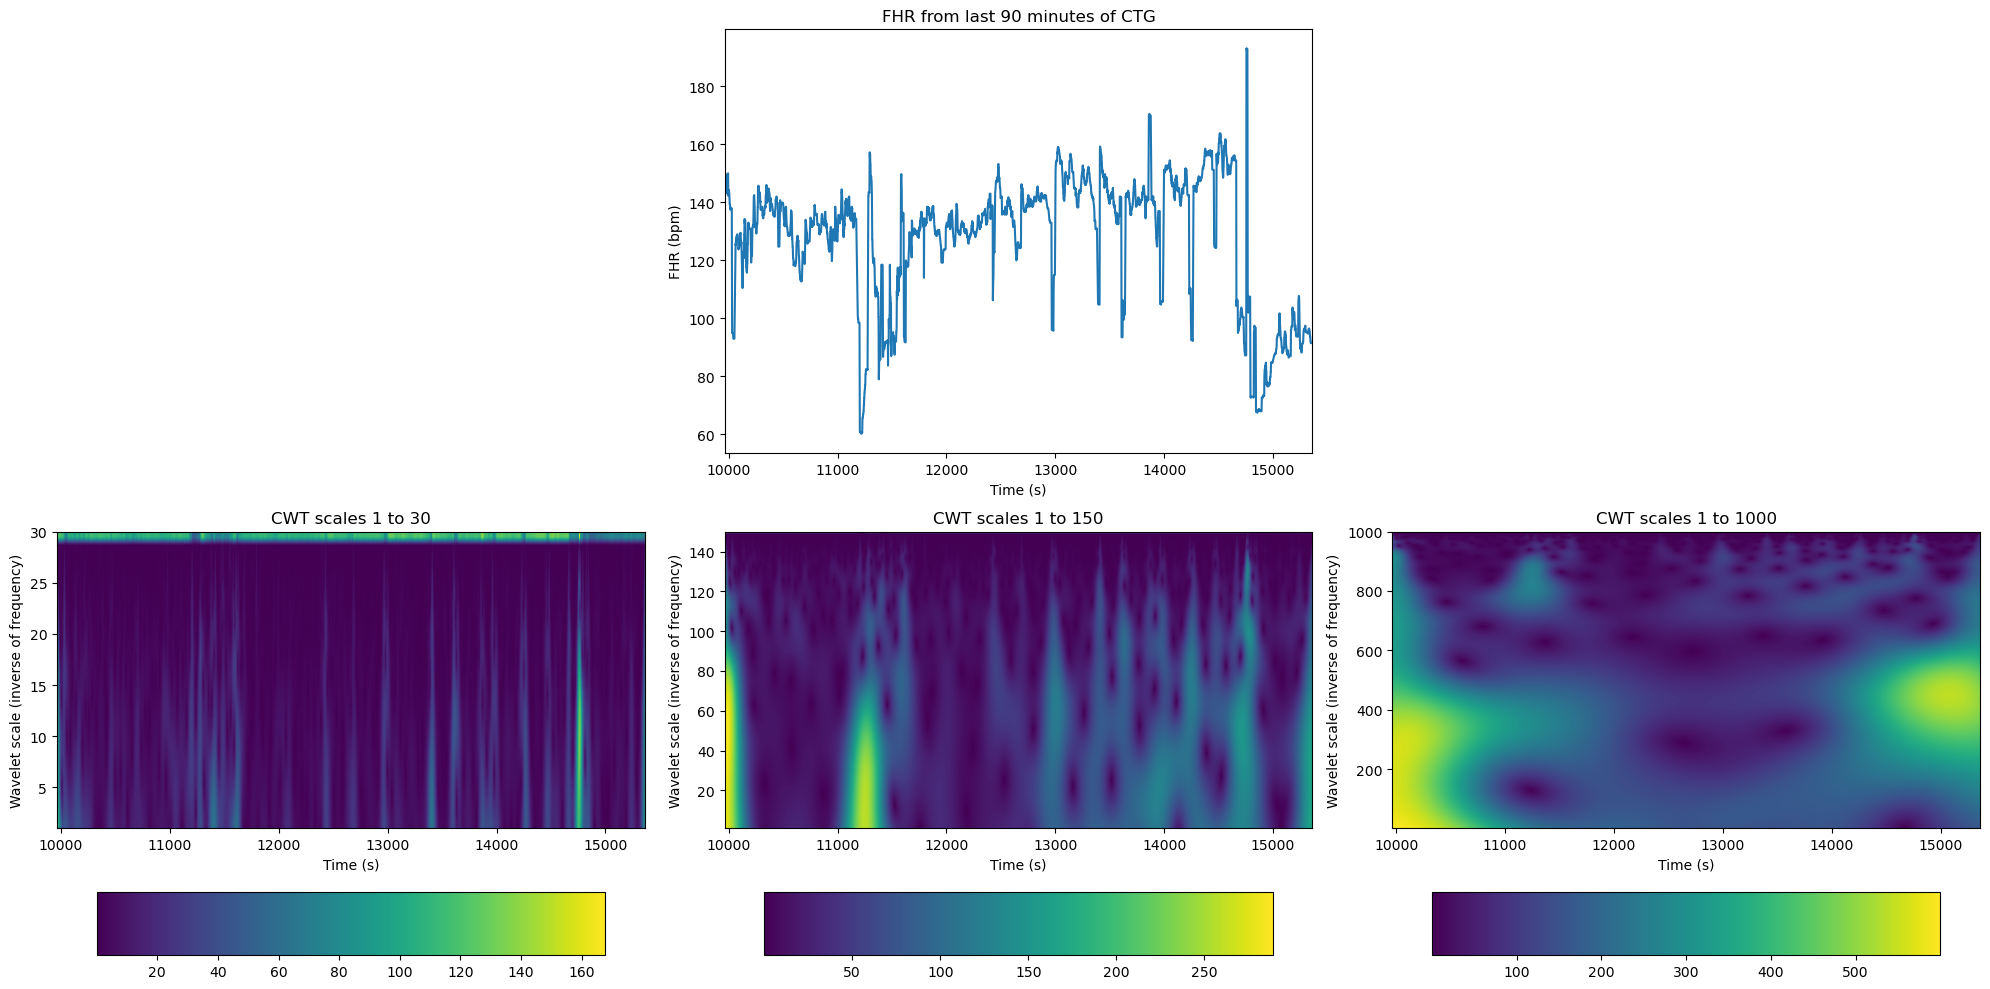

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], scales=np.arange(1, 31), cwt_title='CWT scales 1 to 30')
cwt_plot(ax[0,1], ax[1,1], scales=np.arange(1, 151), cwt_title='CWT scales 1 to 150')
cwt_plot(ax[0,2], ax[1,2], scales=np.arange(1, 1001), cwt_title='CWT scales 1 to 1000')

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,2])

plt.tight_layout()
plt.show()

By increasing the maximum wavelet scale, this should mean we are therefore looking for lower frequencies.

**Observations** - as we increase the range of scales:
* Lose bar of colour from top of chart
* Increased presence of boundary effects - "As the frequency decreases, the width of the CWT coefficients in time that are nonzero and centered on the impulse increases. Conversely, as the frequency increases, the width of the CWT coefficients that are nonzero decreases and becomes increasingly centered on the impulse. Low frequencies correspond to wavelets of longer scale, while higher frequencies correspond to wavelets of shorter scale. The effect of the impulse persists longer in time with longer wavelets. In other words, the longer the wavelet, the longer the duration of influence of the signal. For a wavelet centered at a certain point in time, stretching or shrinking the wavelet results in the wavelet "seeing" more or less of the signal. This is referred to as the wavelet's cone of influence."[[source]](https://uk.mathworks.com/help/wavelet/ug/boundary-effects-and-the-cone-of-influence.html)
* Lose time specificity

**Resulting questions:**
* Does the loss of the bar of colour mean we were previously setting the maximum scale too low?
* How problematic are boundary effects?
* Can we plot the cone of influence in python?

### Using decimal scales <a class="anchor" id="decimal"></a>

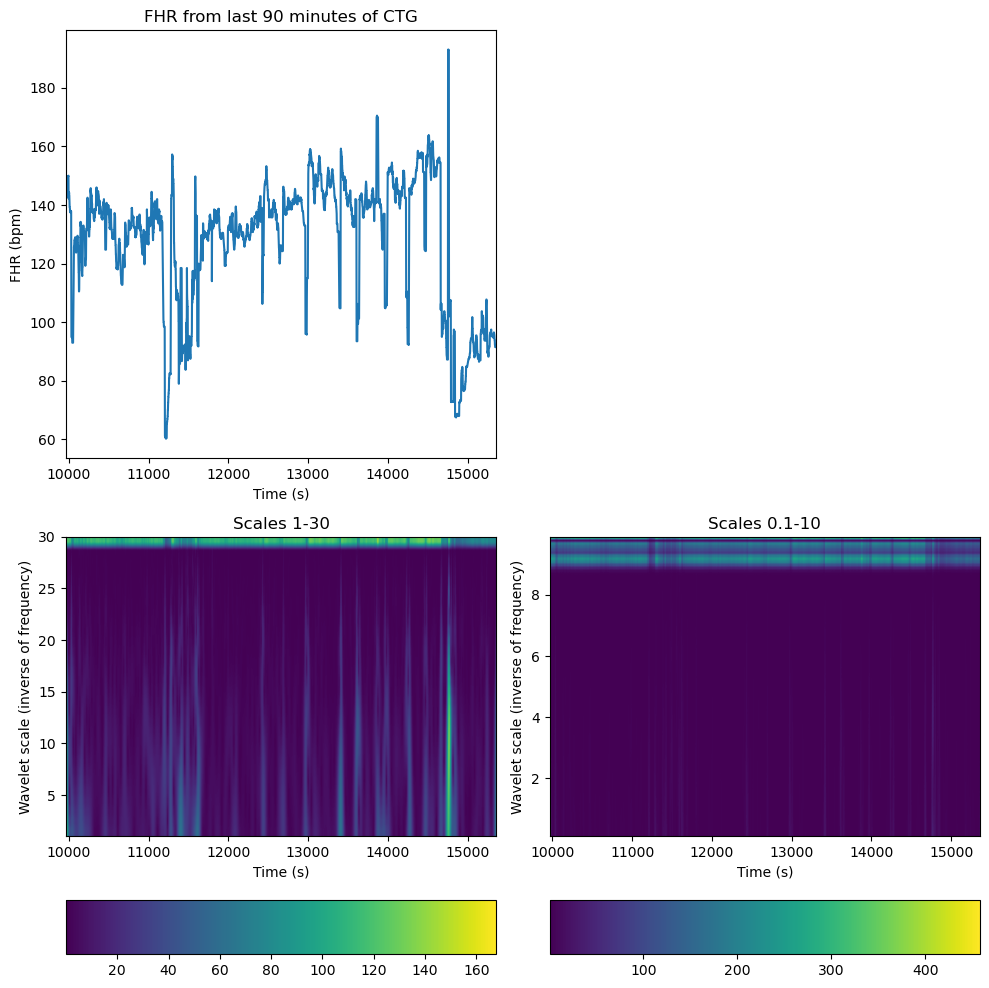

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cwt_plot(ax[0,0], ax[1,0], cwt_title='Scales 1-30')
cwt_plot(ax[0,1], ax[1,1],
         scales=np.arange(0.1, 10, 0.1),
         cwt_title='Scales 0.1-10')

fig.delaxes(ax[0,1])

plt.tight_layout()
plt.show()

**Observations**:
* Blank - presuming that those scales are too small

### Using log scales <a class="anchor" id="log"></a>

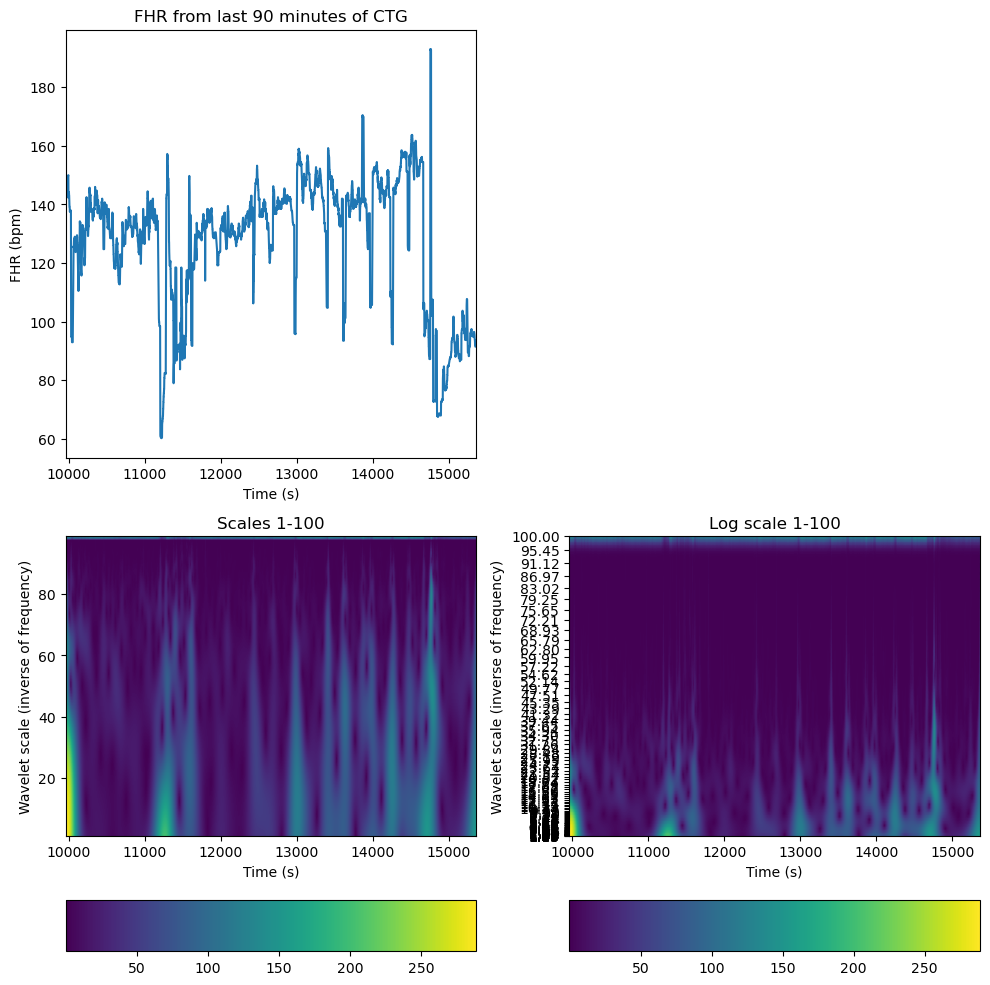

In [10]:
# Generate a log scale from 1 to 100
log_scale = np.logspace(0, 2, num=100)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cwt_plot(ax[0,0], ax[1,0], scales=np.arange(1, 100, 1), cwt_title='Scales 1-100')
cwt_plot(ax[0,1], ax[1,1], scales=log_scale, cwt_title='Log scale 1-100')
ax[1,1].set_yticks(log_scale)

fig.delaxes(ax[0,1])

plt.tight_layout()
plt.show()

Not sure if I've correctly created the figure, as it might be that the log scale labels are like "categorical" labels and should be equally spaced.

Observations:
* Makes the colours appear shorter

### Changing the units of the signal <a class="anchor" id="units"></a>

#### Adding a constant

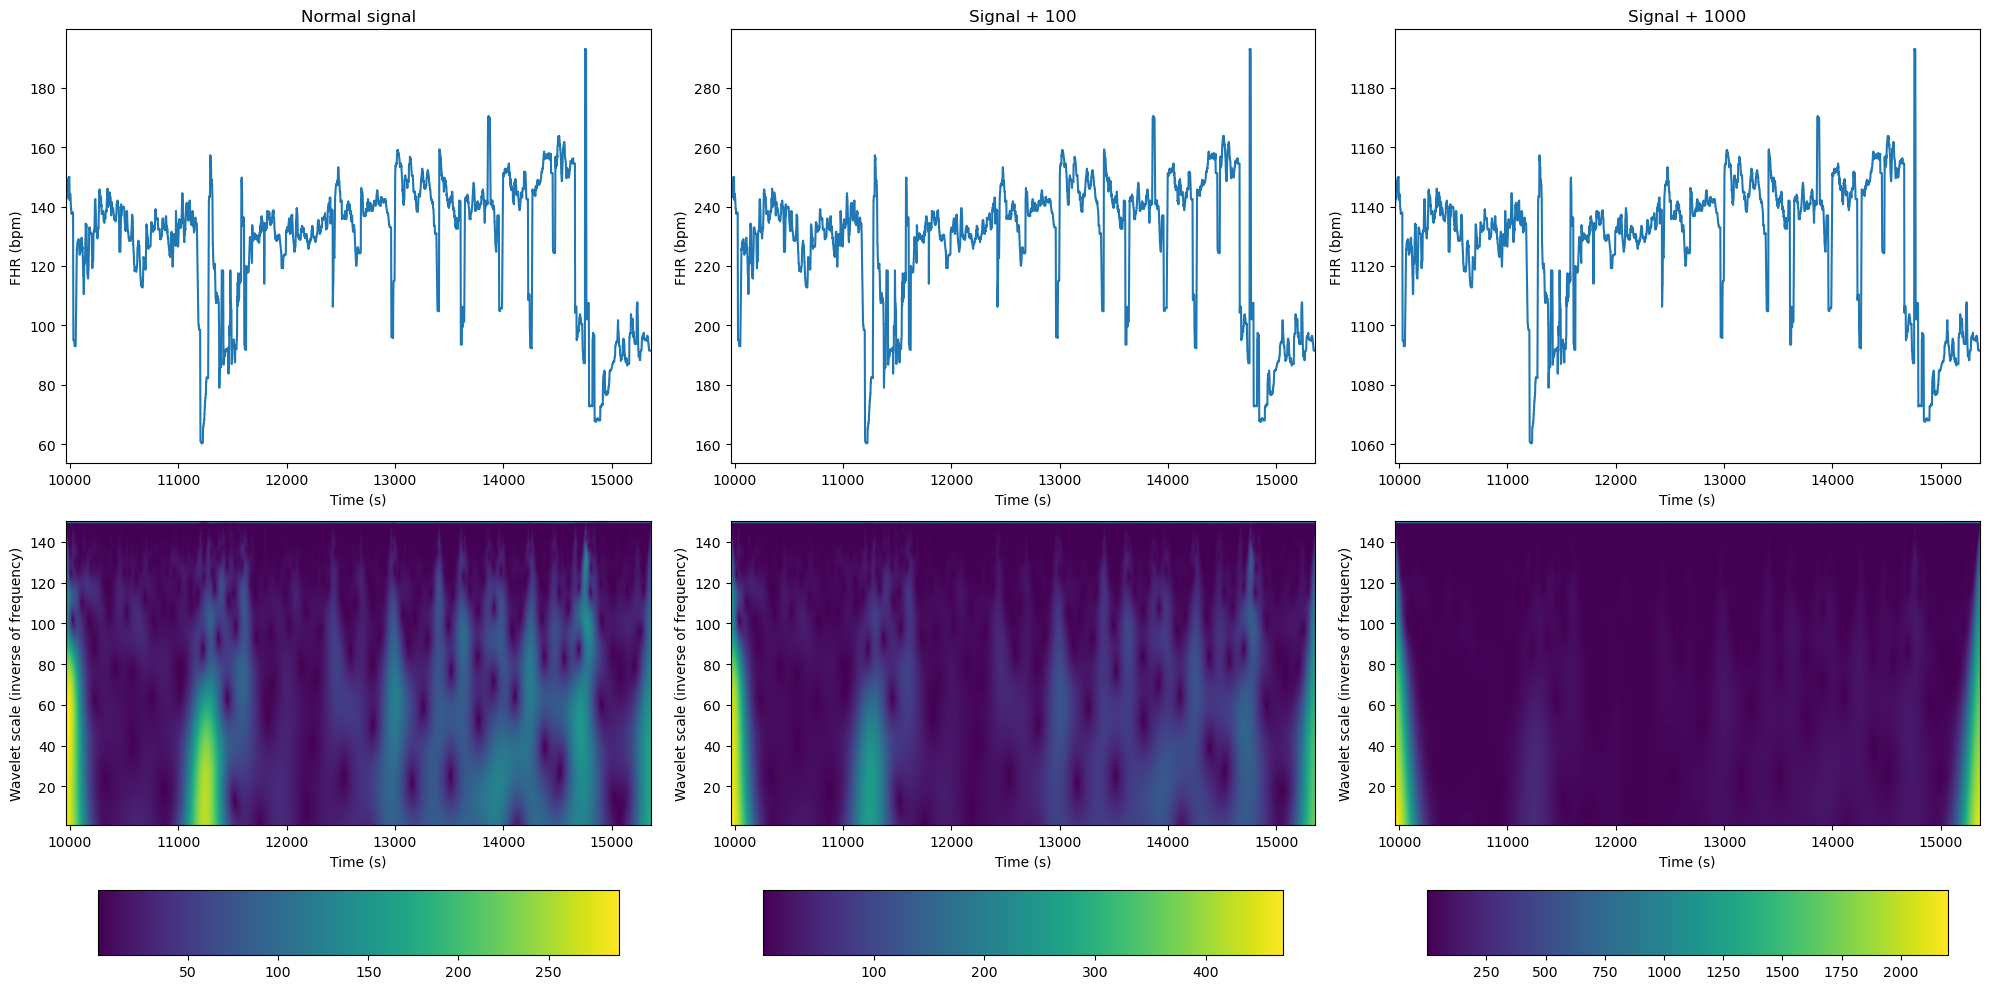

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr+100, scales=np.arange(1, 151),
         sig_title='Signal + 100', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr+1000, scales=np.arange(1, 151),
         sig_title='Signal + 1000', cwt_title='')

plt.tight_layout()
plt.show()

In this example, a constant has been added to the signal

**Observations**:
* **Impacts the scaleogram** - contrary to our expectations that signal scale wouldn't matter, as we had assumed it was just about the shape of the signal
* **Obvious edge-effect artifacts** these are areas where "the stretched wavelets extend beyond the edges of the observation interval". You could draw a cone of influence which would be in the two bottom corners of the figure, and in those, you should be suspicious about edge effects and understand that these may not be an accurate time-frequency representation of the data. These are also referred to as boundary effects.[[source]](https://uk.mathworks.com/help/wavelet/ug/boundary-effects-and-the-cone-of-influence.html)

**Questions**
* Why does this have such a large impact on results? The units used (bpm) aren't exactly meaningful?
* Do the boundary effects occur because the CWT assumes that we're using a periodic signal where, if we repeated the signal periodically, there would be a big jump between the start and end value, causing high amplitude in image?[[source]](https://stackoverflow.com/questions/43787412/strange-behaviour-of-cwt-at-the-end-and-the-beginning-in-matlab)

#### Subtracting a constant

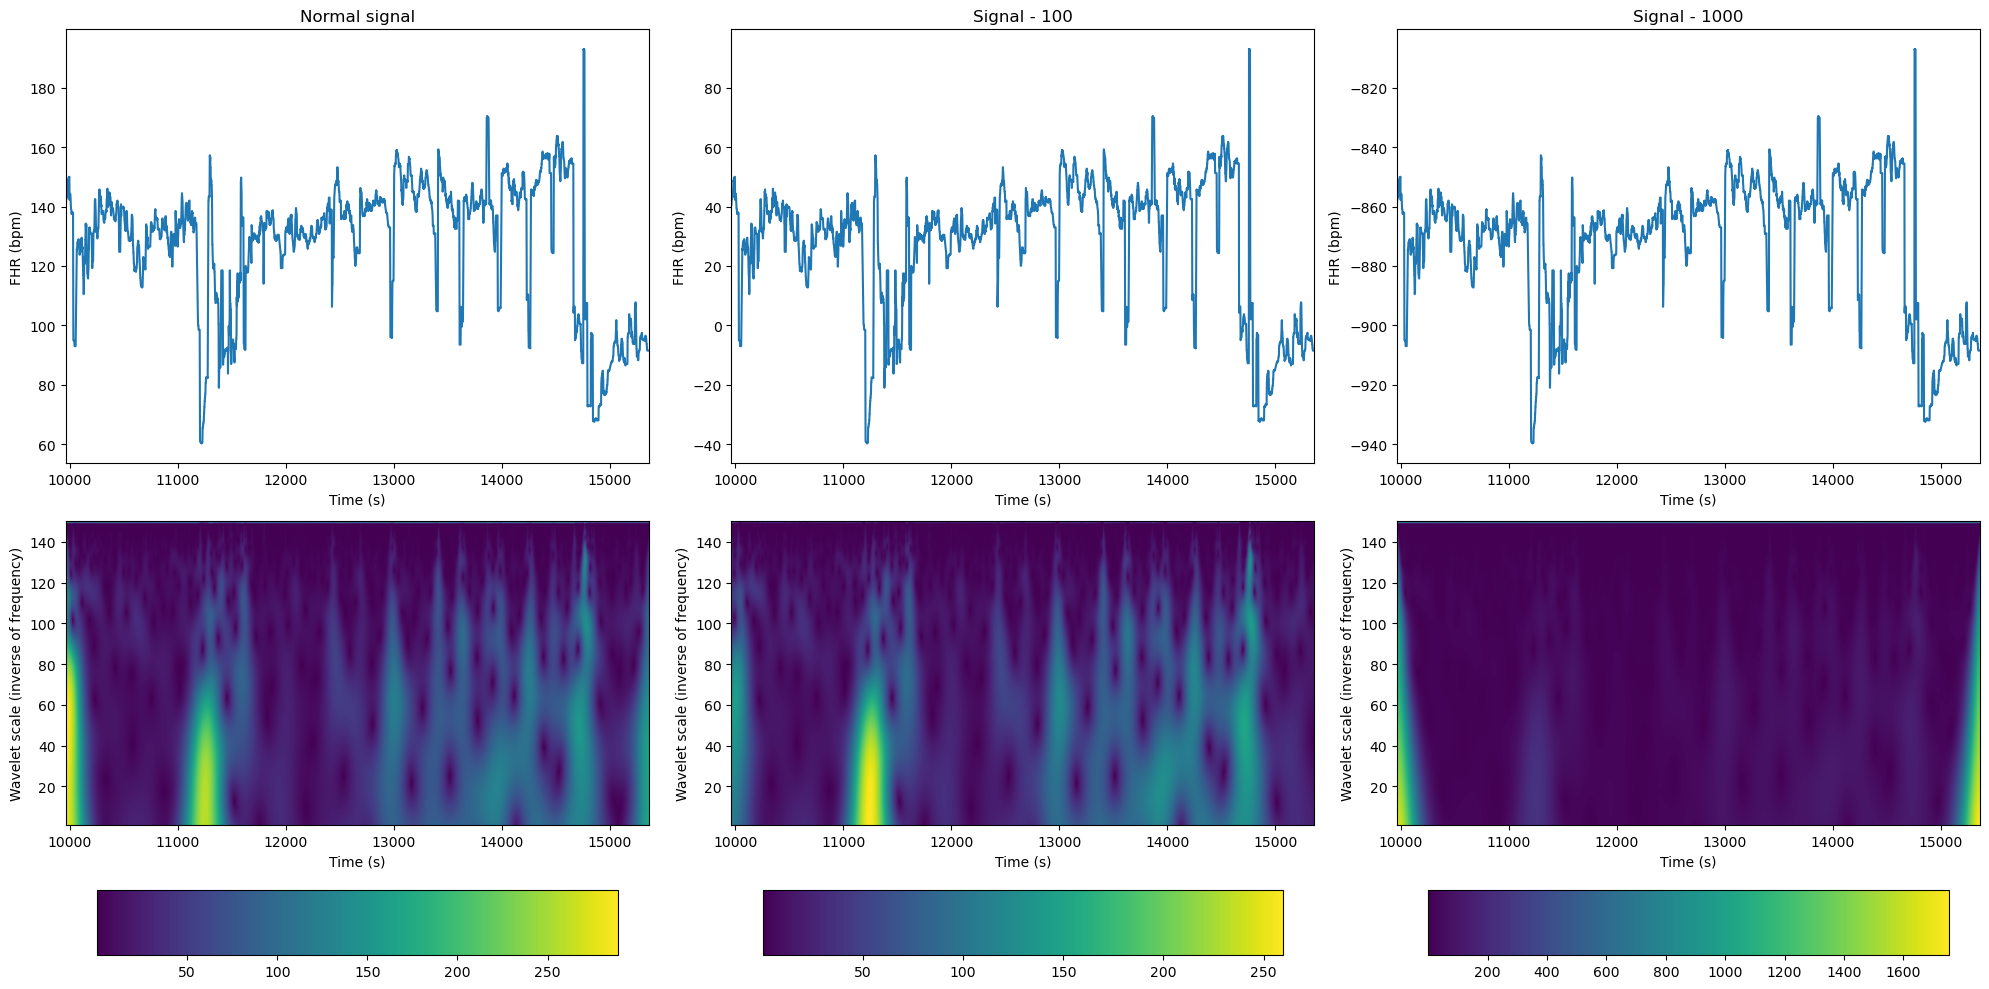

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr-100, scales=np.arange(1, 151),
         sig_title='Signal - 100', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr-1000, scales=np.arange(1, 151),
         sig_title='Signal - 1000', cwt_title='')

plt.tight_layout()
plt.show()

In these examples, a constant is subtracted from the signal

**Observations**:
* When we subtract 100, we actually seem to lose some of the boundary effects

#### Centering or normalising the signal

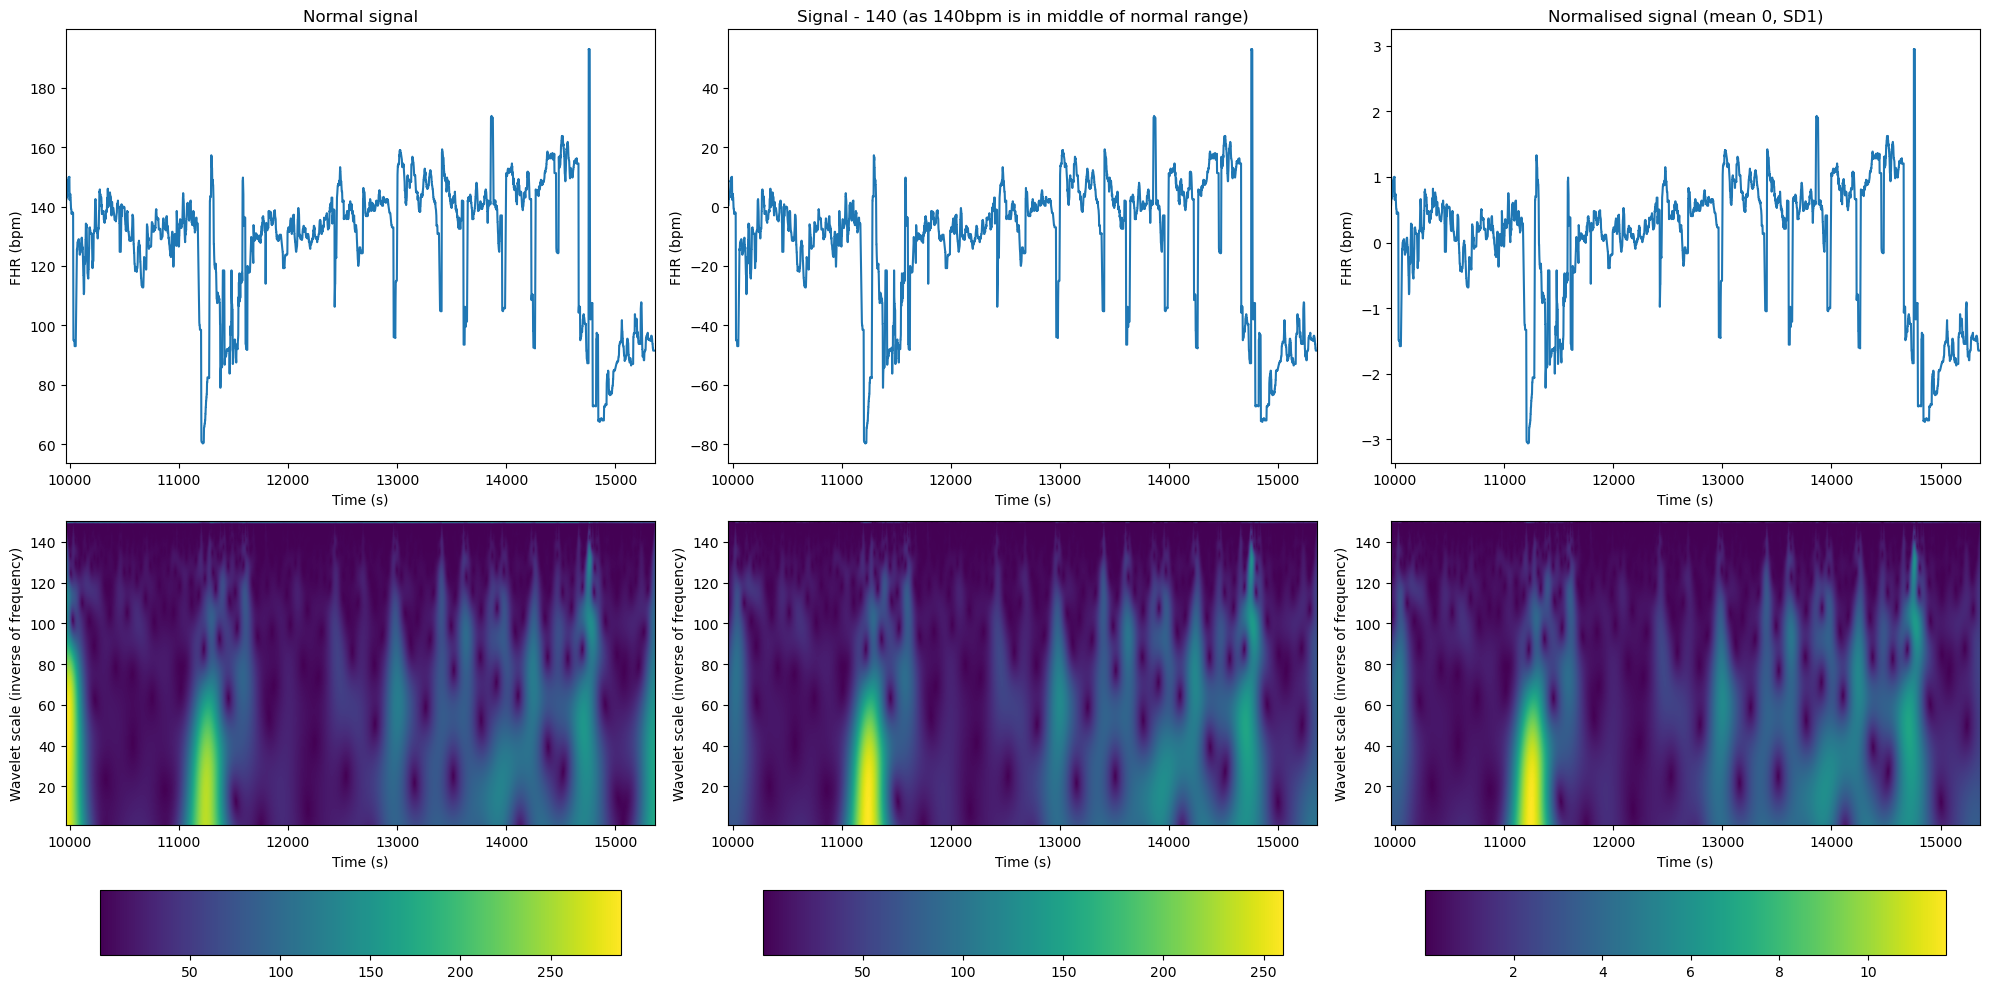

In [13]:
# Normalised signal
fhr_mean = fhr.mean()
fhr_sd = fhr.std()
fhr_norm = (fhr - fhr_mean) / fhr_sd

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr-140, scales=np.arange(1, 151),
         sig_title='Signal - 140 (as 140bpm is in middle of normal range)', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr_norm, scales=np.arange(1, 151),
         sig_title='Normalised signal (mean 0, SD1)', cwt_title='')

plt.tight_layout()
plt.show()

I tried two scenarios:
* Subtracting 140 (as 140bpm is in the middle of the normal FHR range)
* Normalising the signal to have mean 0 and SD 1 (although we wouldn't actually want to do this, as scale is important - it can indicate that a fetus is experiencing unusually low or high rate overall)

**Observations**:
* Normalised and subtraction of 140bpm appear to produce quite similar results

### Smoothing the signal <a class="anchor" id="smooth"></a>

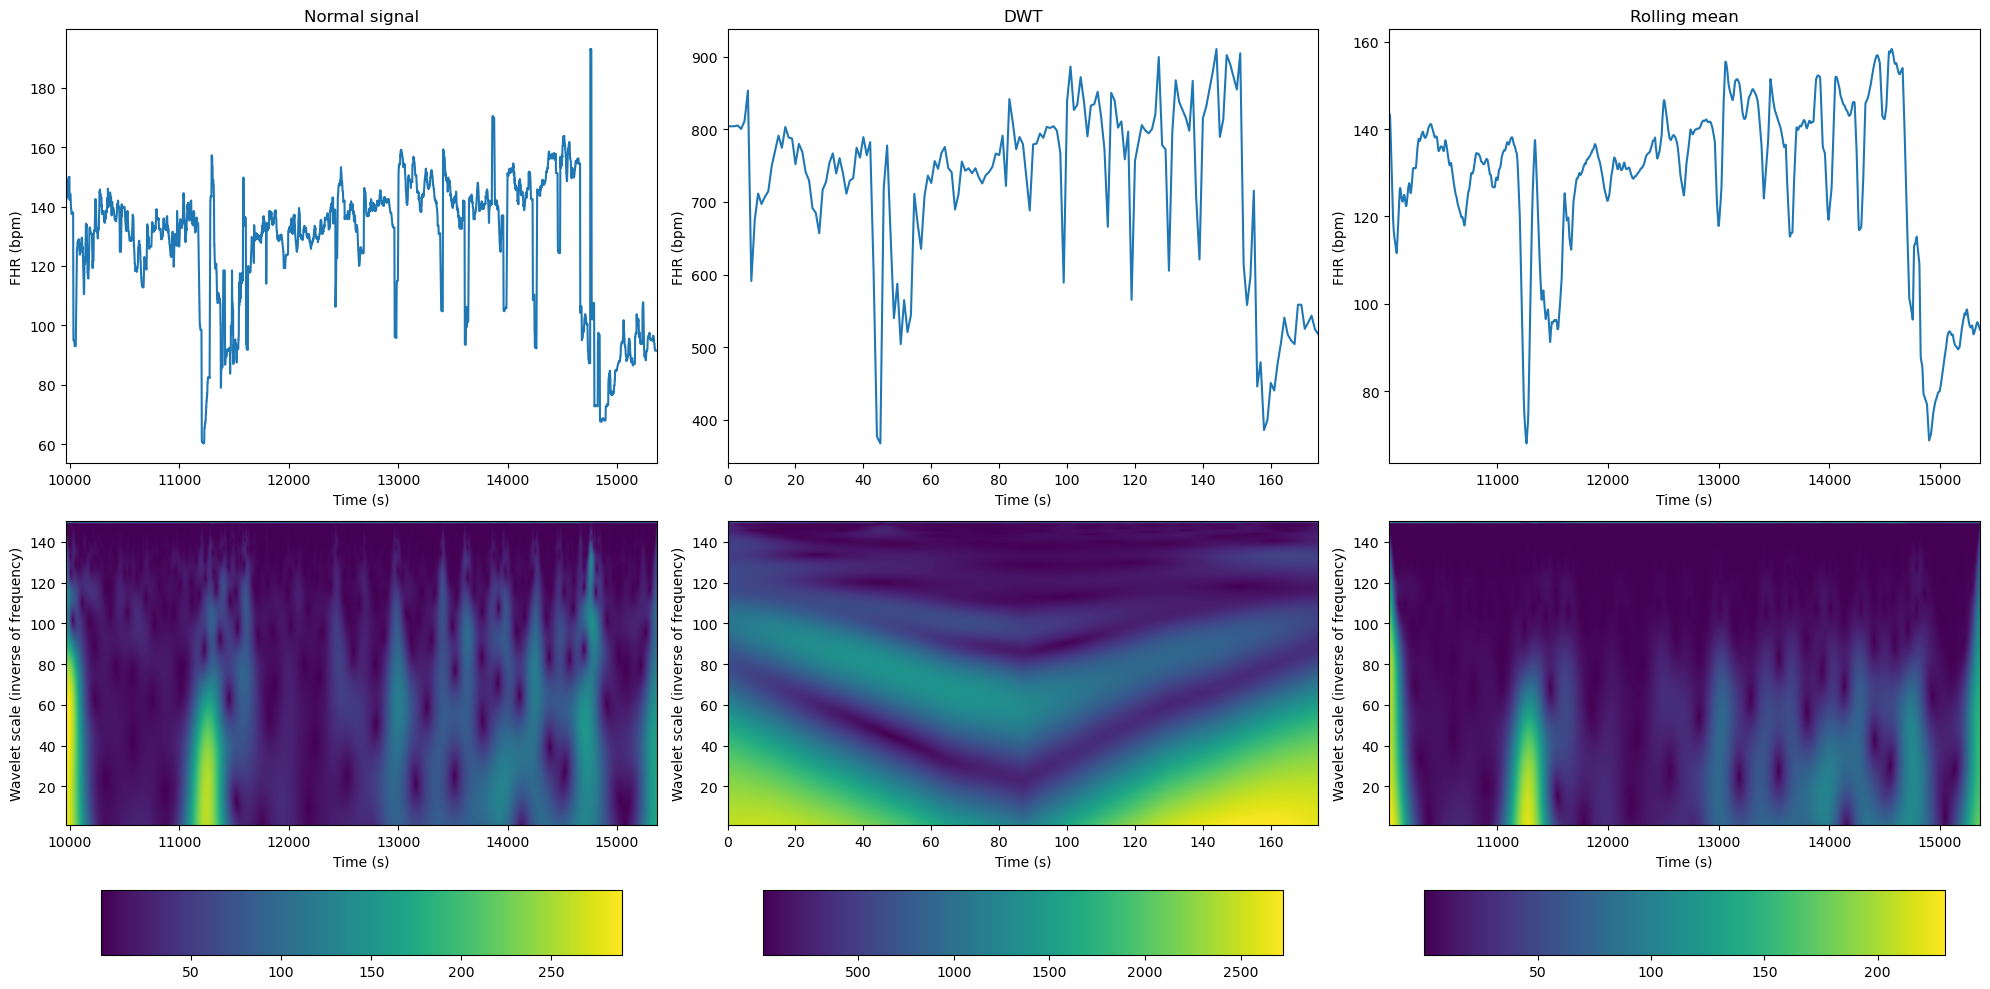

In [14]:
# Perform DWT and take first wavelet
wavelets = pywt.wavedec(fhr, 'db4', level=5)
dwt_fhr = wavelets[0]

# Rolling mean
rolling = fhr.rolling(window=60).mean().dropna()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=pd.Series(dwt_fhr), scales=np.arange(1, 151),
         sig_title='DWT', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=rolling, scales=np.arange(1, 151),
         sig_title='Rolling mean', cwt_title='')

plt.tight_layout()
plt.show()

I tried two different methods of smoothing:
* Using DWT
* Taking a rolling average

**Observations**:
* DWT compressed the signal (note x axis 175) - and I think this loss of information has meant we lose information (either due to CWT length or or boundary effects or something similar)
* Taking a rolling mean seems to have had little impact on the results

### Using CWT on FHR records with known anomalies <a class="anchor" id="anomalies"></a>

Record 1001 (the first record which I used for everything above, not sure if there are any known anomalies present)

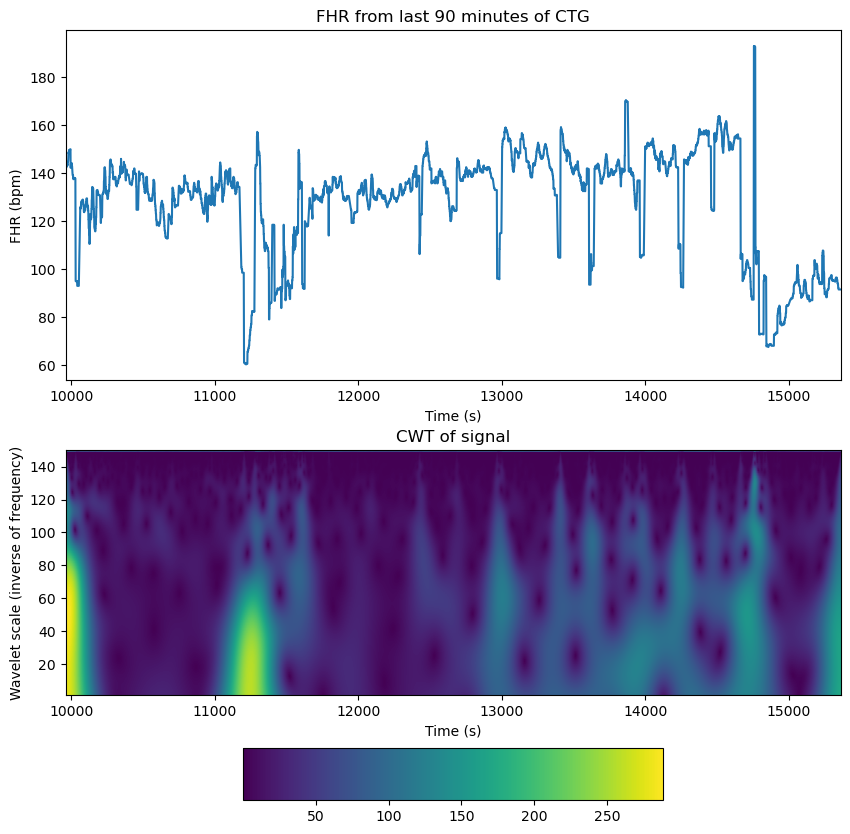

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr)

Record 1036 which has tachycardia (FHR faster than normal)

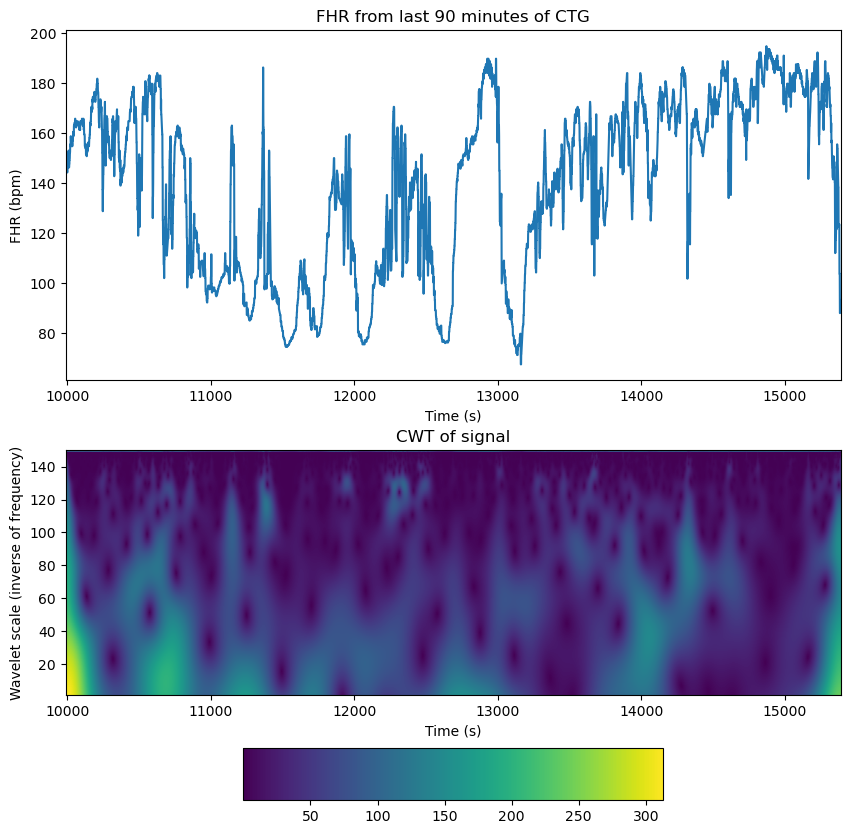

In [16]:
fhr_alt = pd.read_csv('data_fhr_clean/1036.csv')['FHR'].tail(90*60)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)

Record 1317 which has bradychardia (FHR slower than normal)

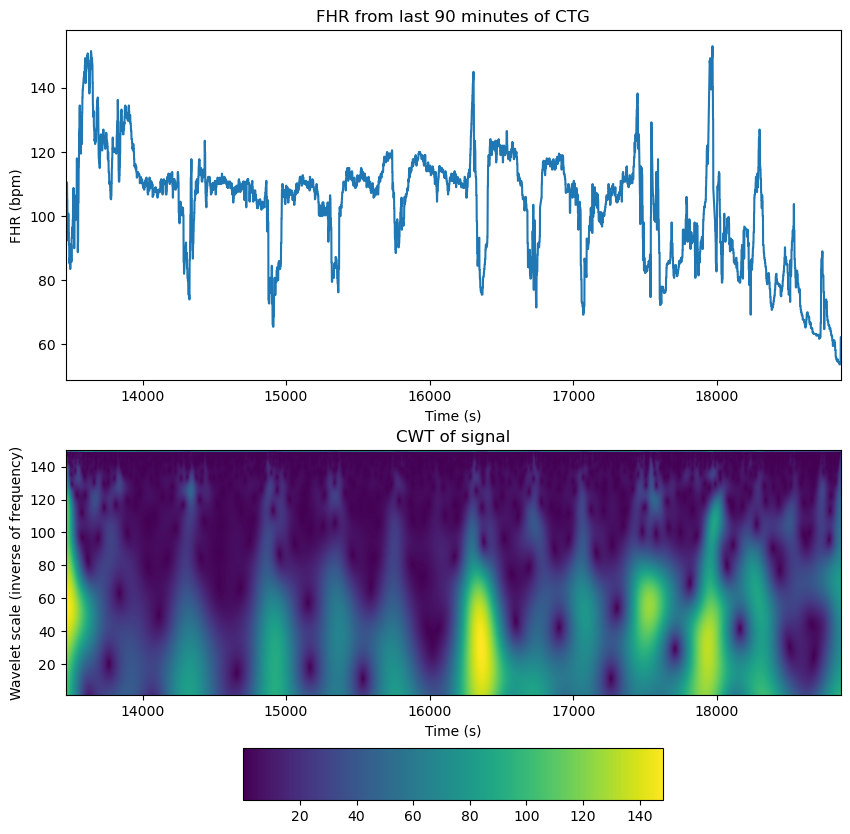

In [17]:
fhr_alt = pd.read_csv('data_fhr_clean/1317.csv')['FHR'].tail(90*60)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)

Record 1176 which has accelerations and decelerations

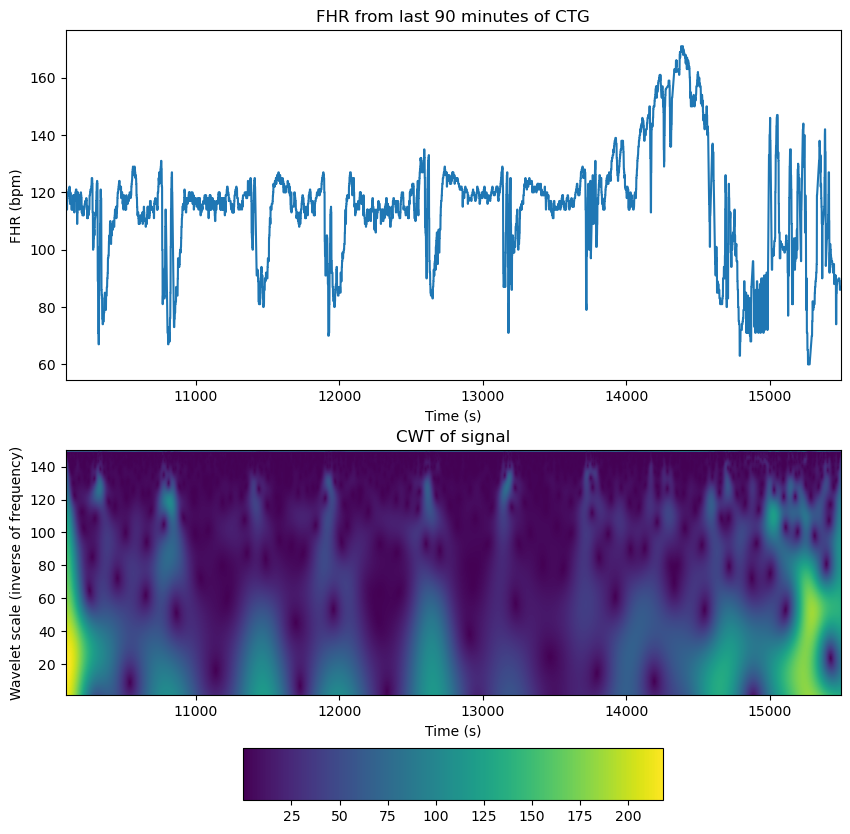

In [18]:
fhr_alt = pd.read_csv('data_fhr_clean/1176.csv')['FHR'].tail(90*60)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)